In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle as pkl
import torch
from numpy.linalg import matrix_power
from scipy.stats import rv_discrete
from scipy.linalg import expm, sinm, cosm
from numpy.linalg import matrix_power
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle as pkl
from scipy.linalg import expm, sinm, cosm
from numpy.linalg import matrix_power
from scipy.special import factorial
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime
import time
import math
from torch.utils.data import Dataset, DataLoader
import sys


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Loading NNs

## Inv stationary: NN 1

In [ ]:
num_arrival_moms, num_ser_moms = 5, 5
import torch
import torch.nn as nn
class Net_inv(nn.Module):

    def __init__(self, input_size, output_size):
        
        super().__init__()
        
        self.fc1 = nn.Linear(input_size , 50)
        self.fc2 = nn.Linear(50, 70)
        self.fc3 = nn.Linear(70, 100)
        self.fc4 = nn.Linear(100, 90)
        self.fc5 = nn.Linear(90, 60)
        self.fc6 = nn.Linear(60, output_size)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x  


path_valid_batch_inv = r'.\data\inventory_data'
files = os.listdir(path_valid_batch_inv)
data_paths_valid_inv = [os.path.join(path_valid_batch_inv, name) for name in files]


dataset_valid_inv = my_Dataset(data_paths_valid_inv,  num_arrival_moms, num_ser_moms)
batch_size = 1
valid_loader = DataLoader(dataset=dataset_valid_inv,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

# get first sample and unpack
first_data_inv = dataset_valid_inv[0]
features_inv, labels_inv = first_data_inv
print(features_inv.shape, labels_inv.shape)

m = nn.Softmax(dim=1)
input_size_inv = features_inv.shape[1]
output_size_inv = labels_inv.shape[1]
net_inv = Net_inv(input_size_inv, output_size_inv).to(device)
model_inv = 'lead_time_no_neg_5_layer_6_S_175_layer_6.pkl'
net_inv.load_state_dict(torch.load(os.path.join(model_path, model_inv)))

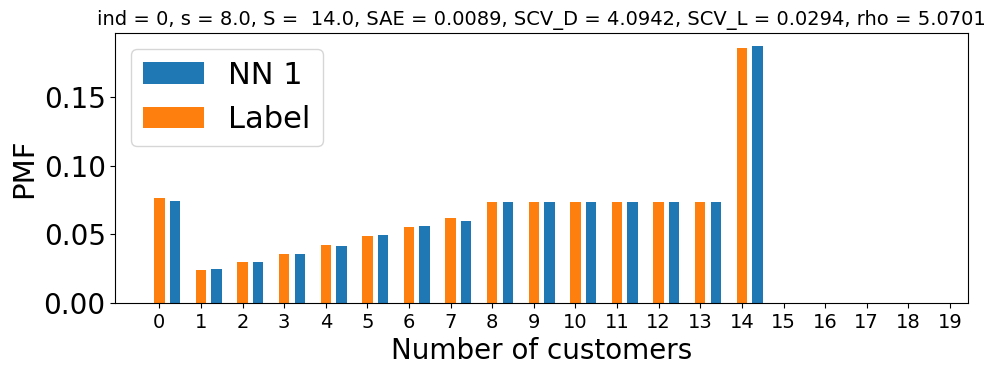

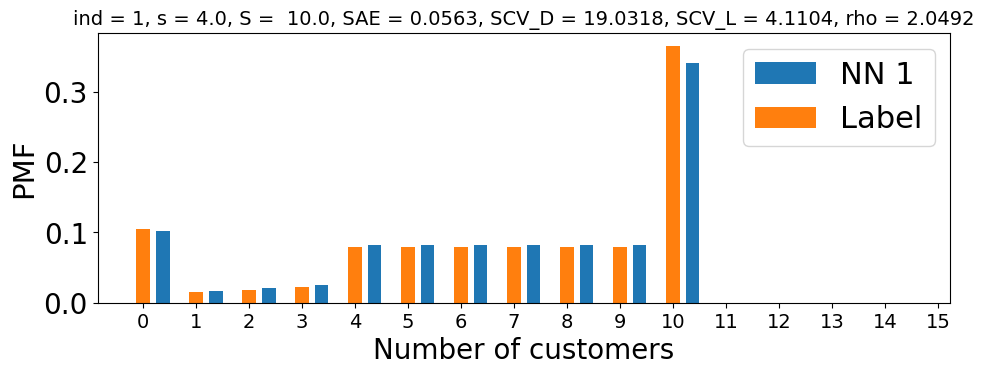

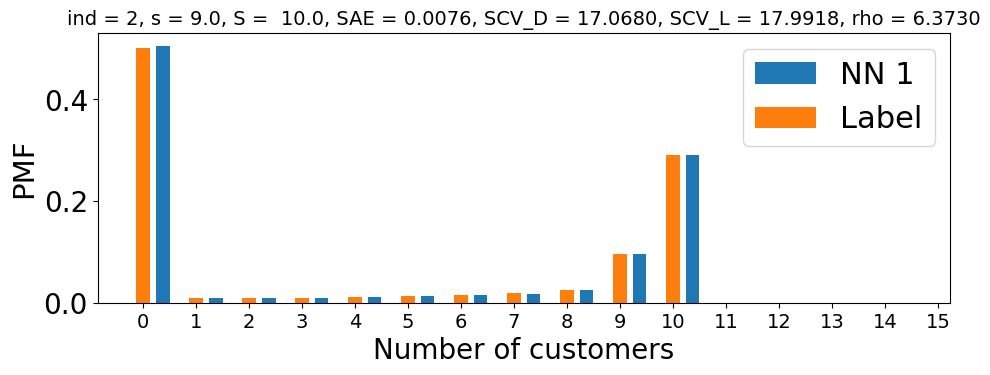

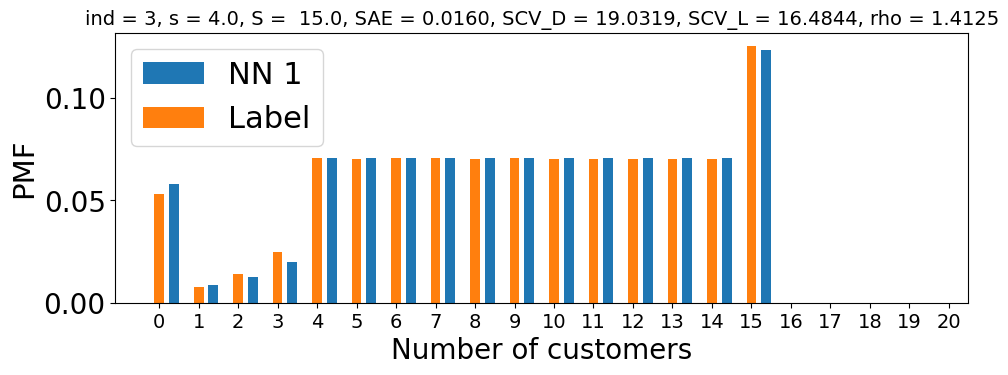

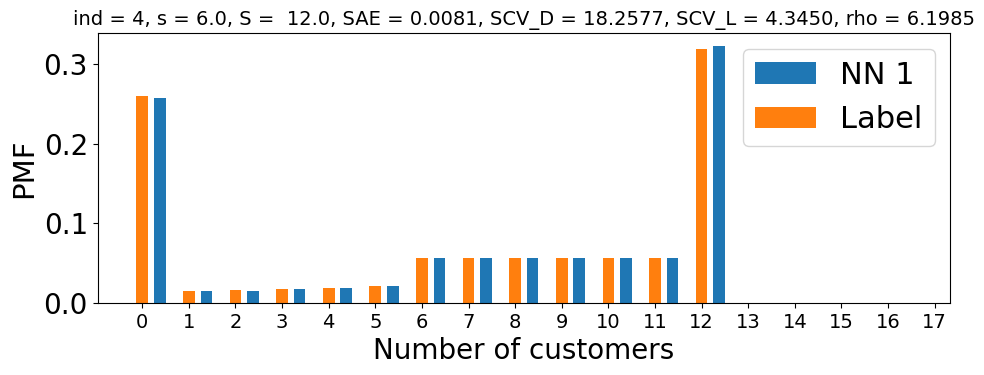

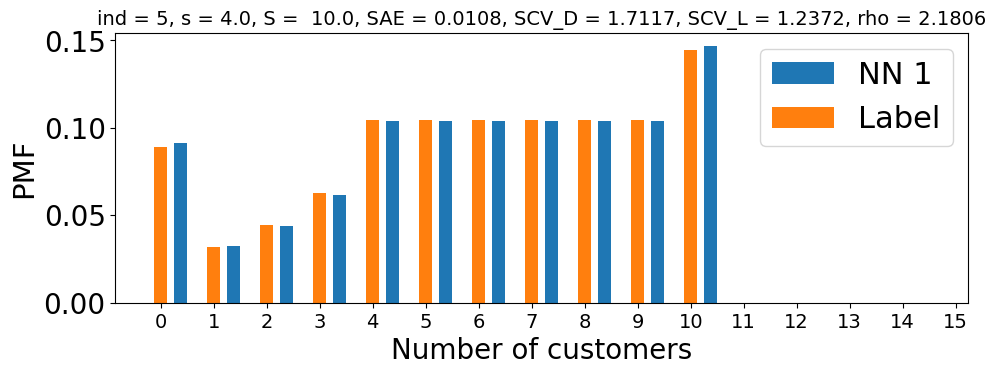

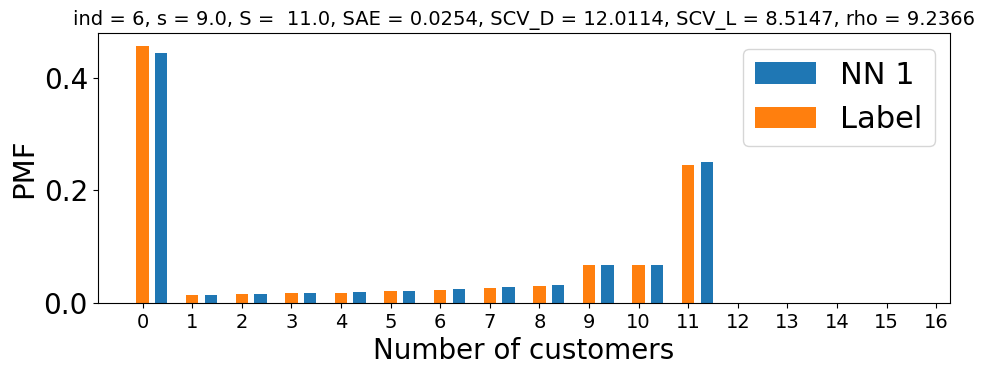

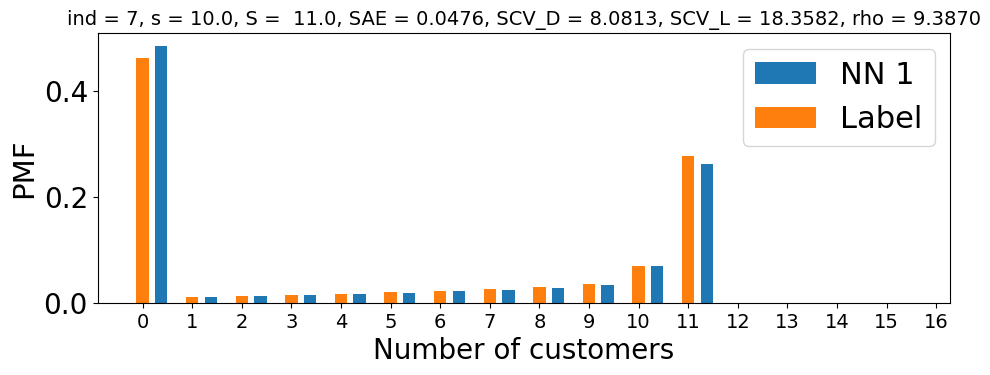

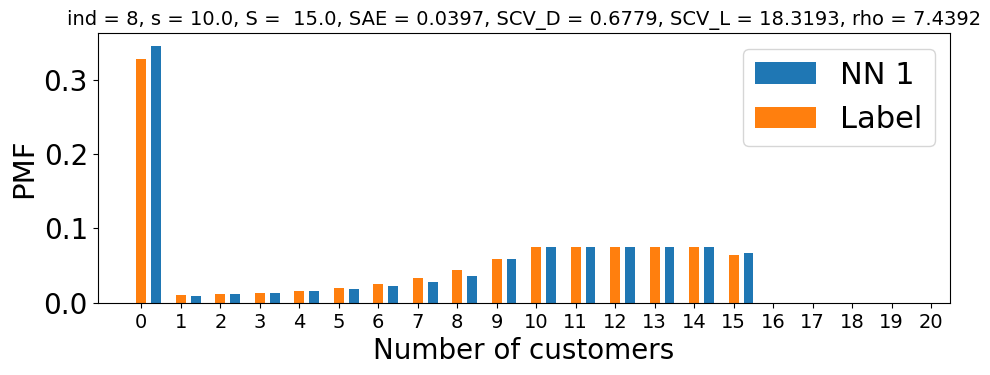

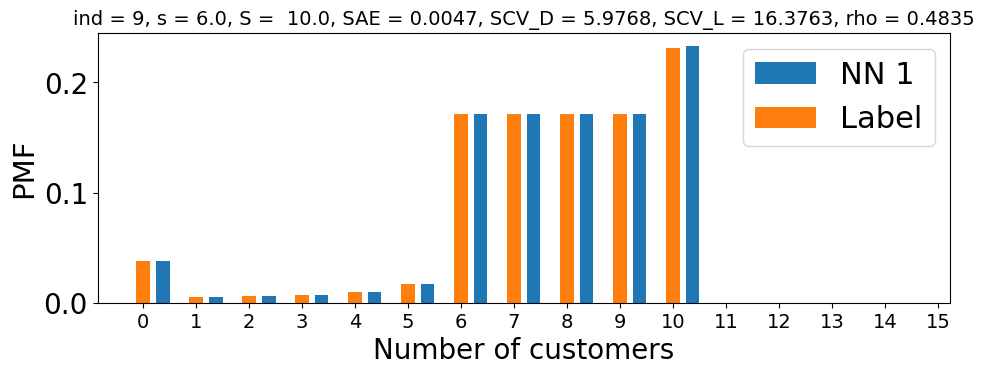

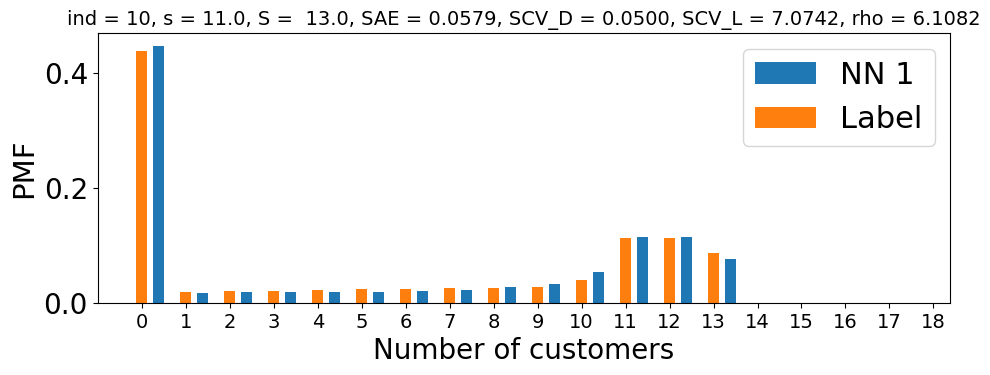

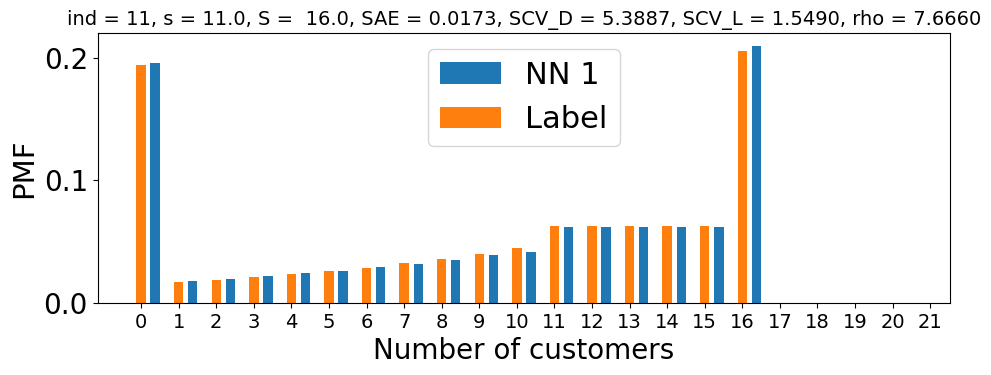

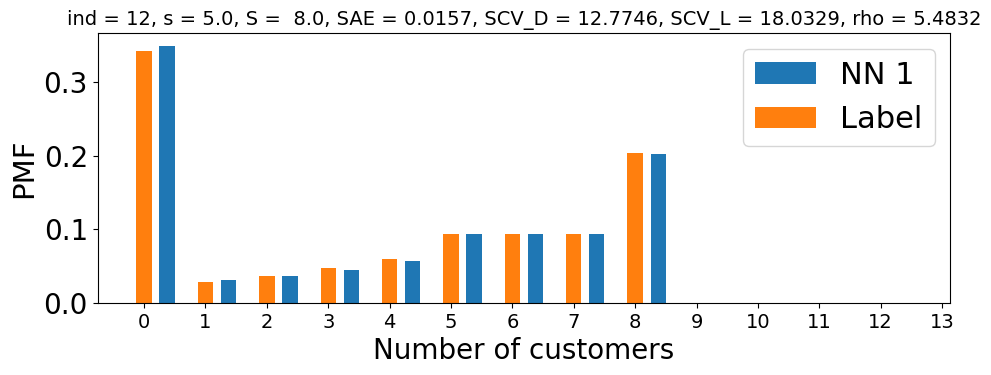

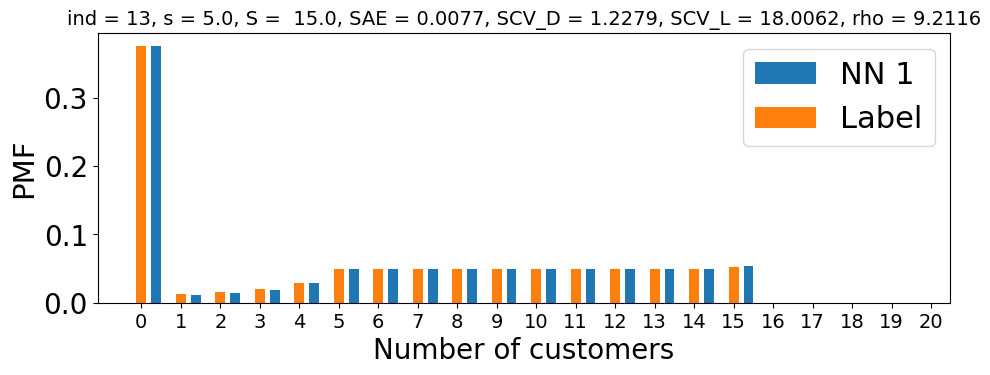

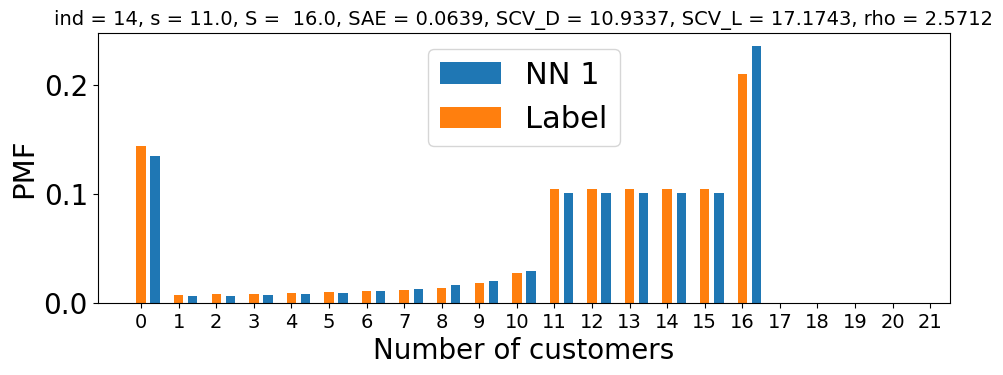

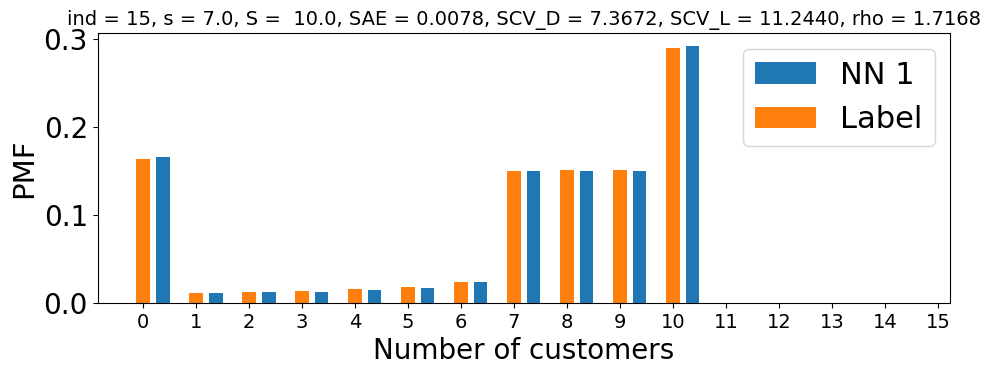

In [128]:
inp = features_inv.to(device)


S = inp[:, -1].int()
s = inp[:, -2].int()
output = net_inv(features_inv.to(device).float())


cols = torch.arange(output.size(1), device='cuda')
mask = cols.unsqueeze(0) <= S.unsqueeze(1)  # shape: (3, 4)
logits = output.masked_fill(~mask, float('-inf'))
output1 = m(logits)

predictions = output1
cols = torch.arange(predictions.size(1), device='cuda')
mask1 = (cols.unsqueeze(0) >= s.unsqueeze(1)) & (cols.unsqueeze(0) < S.unsqueeze(1))
new_out = mask1 * predictions
# x: (16, 51) tensor
mask = new_out != 0
only_bet_vals = mask*predictions


mask = only_bet_vals != 0                          # True where non-zero
means = (only_bet_vals * mask).sum(dim=1) / mask.sum(dim=1)   # mean per row of non-zeros
means = means.unsqueeze(1)             # shape (16,1) for broadcasting

x_new = only_bet_vals.clone()
x_new[mask] = means.expand_as(only_bet_vals)[mask]
x_new[~mask] = predictions[~mask]

with torch.no_grad():
    for ind in range(x_new.shape[0]):
        output1 = x_new
        y_valid = labels_inv
        SAE = torch.abs(output1[ind].to('cpu') - y_valid[ind]).sum().cpu()
        Demand_scv = (torch.exp(features_inv[:,1])-1).cpu()
        Leadtime_SCV =  ((torch.exp(features_inv[:,1+num_arrival_moms]) - torch.exp(features_inv[:,num_arrival_moms])**2)/torch.exp(features_inv[:,num_arrival_moms])**2).cpu()
        rhos = torch.exp(features_inv[:,num_arrival_moms]).cpu()
        
        fig, (ax1) = plt.subplots(1, 1, figsize=(11, 3.5))
        width = 0.25
        max_probs = int(features_inv[ind, -1].item())
        rects1 = ax1.bar(1.5*width+np.arange(min(35,max_probs+5)), output1[ind,:min(35,max_probs+5)].cpu(), width, label='NN 1')
        rects2 = ax1.bar(np.arange(min(35,max_probs+5)) , y_valid[ind,:min(35,max_probs+5)].cpu(), width, label='Label')
        plt.rcParams['font.size'] = '20'
        
        # # Add some text for labels, title and custom x-axis tick labels, etc.
        ax1.set_ylabel('PMF', fontsize=21)
        ax1.set_xlabel('Number of customers', fontsize=20)
        ax1.set_title( 'Presenting L distribution' , fontsize=21, fontweight="bold")
        ax1.set_xticks(np.linspace(0,min(35,max_probs+5),min(35,max_probs+5)+1).astype(int))
        ax1.set_xticklabels(np.linspace(0,min(35,max_probs+5),min(35,max_probs+5)+1).astype(int), fontsize=14)
        ax1.legend(fontsize=22)
        plt.title('ind = {}, s = {}, S =  {}, SAE = {:.4f}, SCV_D = {:.4f}, SCV_L = {:.4f}, rho = {:.4f}' .format(ind, str(features_inv[ind, -2].item()), str(features_inv[ind, -1].item()),SAE.item(),Demand_scv[ind].item(), Leadtime_SCV[ind].item(), rhos[ind].item()) , fontsize=14)
        plt.show()    

## Mean cycle time: NN 2

In [62]:
class Net_cycle(nn.Module):

    def __init__(self, input_size, output_size = 1):
        
        super().__init__()
        
        self.fc1 = nn.Linear(input_size , 50)
        self.fc2 = nn.Linear(50, 70)
        self.fc3 = nn.Linear(70, 70)
        self.fc4 = nn.Linear(70, 60)
        self.fc5 = nn.Linear(60, 50)
        self.fc6 = nn.Linear(50, output_size)



    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x  

In [74]:
path_valid_batch_cycle = r'.\data\cycle_time_data'
files = os.listdir(path_valid_batch_cycle)
data_paths_valid_cycle = [os.path.join(path_valid_batch_cycle, name) for name in files]


dataset_valid_cycle = my_Dataset(data_paths_valid_cycle,  num_arrival_moms, num_ser_moms)
batch_size = 1
valid_loader = DataLoader(dataset=dataset_valid_cycle,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

# get first sample and unpack
first_data_cycle = dataset_valid_cycle[0]
features_cycle, labels_cycle = first_data_cycle
print(features_cycle.shape, labels_cycle.shape)

torch.Size([16, 12]) torch.Size([16, 1])


In [80]:
model_cycle = 'cycle_time_num_moms_5_layer_6.pkl'
input_size_cycle = features_cycle.shape[1]
output_size_cycle = labels_cycle.shape[1]
net_cycle = Net_cycle(input_size_cycle, output_size_cycle).to(device)
net_cycle.load_state_dict(torch.load(os.path.join(model_path, model_cycle)))

C:\Users\Eshel\AppData\Local\Temp\ipykernel_16744\858897031.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_cycle.load_state_dict(torch.load(os.path.join(model_path,

<All keys matched successfully>

In [81]:
preds_cycle = net_cycle(features_cycle.to(device).float())
print(preds_cycle.shape)
with torch.no_grad():
    preds_cycle = np.array(preds_cycle.to('cpu'))[:,0]

torch.Size([16, 1])


C:\Users\Eshel\AppData\Local\Temp\ipykernel_16744\1153194294.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  preds_cycle = np.array(preds_cycle.to('cpu'))[:,0]


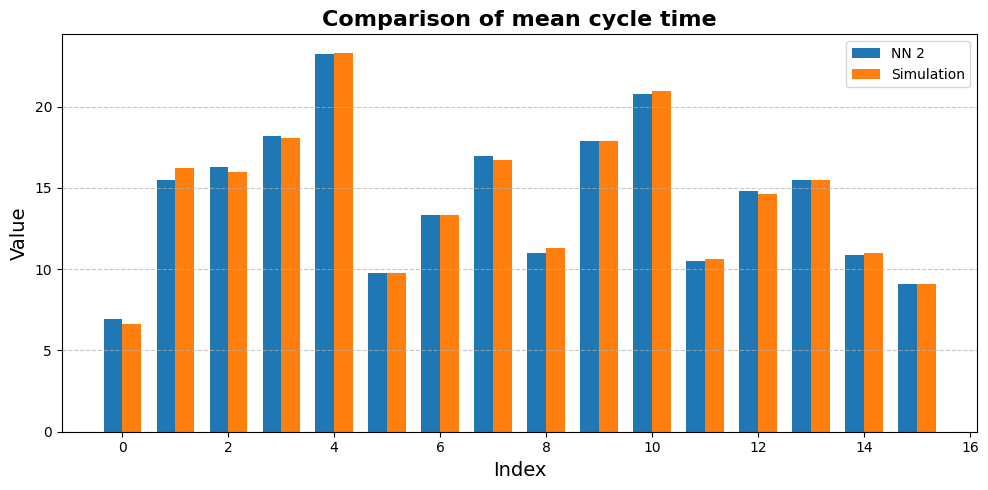

In [84]:
# Example data

# Create an array for the x positions
x = np.arange(len(preds_cycle))  # [0, 1, 2, ..., 15]

# Bar width (adjust for spacing)
width = 0.35

plt.figure(figsize=(10, 5))

# Plot bars side by side
plt.bar(x - width/2, preds_cycle, width, label='NN 2')
plt.bar(x + width/2, labels_cycle[:,0], width, label='Simulation')

# Labels and title
plt.xlabel('Index', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Comparison of mean cycle time', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## Fullfillment probability: NN 3

In [125]:
import torch
import torch.nn as nn
class Net_full(nn.Module):

    def __init__(self, input_size, output_size = 1):
        
        super().__init__()
        
        self.fc1 = nn.Linear(input_size , 50)
        self.fc2 = nn.Linear(50, 70)
        self.fc3 = nn.Linear(70, 70)
        self.fc4 = nn.Linear(70, 60)
        self.fc5 = nn.Linear(60, 10)
        self.fc6 = nn.Linear(10, output_size)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x  

class my_Dataset(Dataset):
    # Characterizes a dataset for PyTorch
    def __init__(self, data_paths,  num_arrival_moms=5, num_ser_moms = 5):
        self.data_paths = data_paths
        self.num_arrival_moms = num_arrival_moms
        self.num_ser_moms = num_ser_moms
        
    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, index):
        x, y = pkl.load(open(self.data_paths[index] , 'rb'))
        x1 = x[:, :self.num_arrival_moms]
        x2 = x[:,10: 10+self.num_ser_moms]
        x3 = x[:,20:]
        x = np.concatenate((x1,x2,x3), axis = 1)
        
        inputs = torch.from_numpy(x)
        y = torch.from_numpy(y)

        return inputs, y
    



In [126]:
path_valid_batch = r'.\data\fullfillment_data'
files = os.listdir(path_valid_batch)
data_paths_valid = [os.path.join(path_valid_batch, name) for name in files]
data_paths_valid

dataset_valid = my_Dataset(data_paths_valid,  num_arrival_moms, num_ser_moms)
batch_size = 1
valid_loader = DataLoader(dataset=dataset_valid,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

# get first sample and unpack
first_data = dataset_valid[0]
features_full, labels_full = first_data
print(features_full.shape, labels_full.shape)
input_size_full = features_full.shape[1]
output_size_full = labels_full.shape[1]
net_full = Net_full(input_size_full, output_size_full).to(device)

model_name_full = 'fullfill_5_layer_6.pkl'
model_path =  r'.\models'

net_full.load_state_dict(torch.load(os.path.join(model_path, model_name_full)))

torch.Size([16, 12]) torch.Size([16, 1])


C:\Users\Eshel\AppData\Local\Temp\ipykernel_16744\173250170.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_full.load_state_dict(torch.load(os.path.join(model_path,

<All keys matched successfully>

C:\Users\Eshel\AppData\Local\Temp\ipykernel_16744\2541957529.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  preds = np.array(preds.to('cpu'))[:,0]


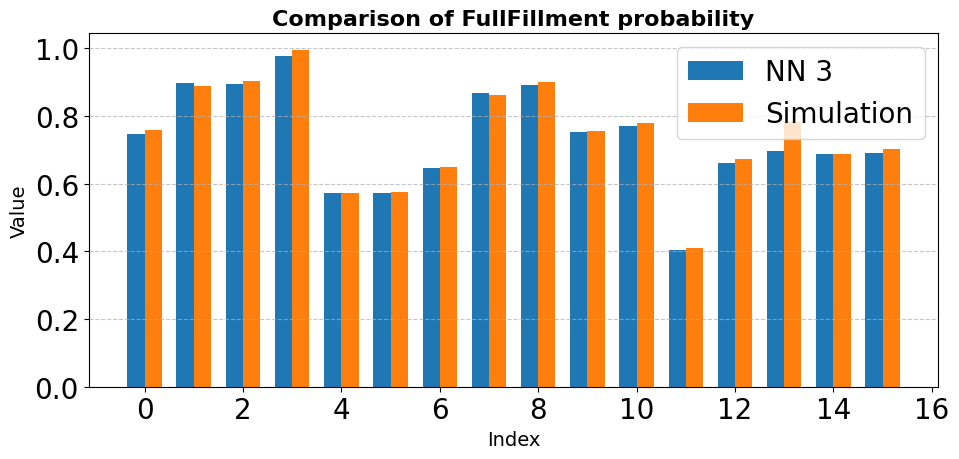

In [127]:
import numpy as np
import matplotlib.pyplot as plt

preds = torch.sigmoid(net_full(features_full.to(device).float()))
with torch.no_grad():
    preds = np.array(preds.to('cpu'))[:,0]
# Example data

# Create an array for the x positions
x = np.arange(len(preds))  # [0, 1, 2, ..., 15]

# Bar width (adjust for spacing)
width = 0.35

plt.figure(figsize=(10, 5))

# Plot bars side by side
plt.bar(x - width/2, preds, width, label='NN 3')
plt.bar(x + width/2, labels_full[:,0], width, label='Simulation')

# Labels and title
plt.xlabel('Index', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Comparison of FullFillment probability', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()